In [158]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
!pip install keras
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('punkt')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import sentiwordnet as swn
import string
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [160]:
def load_dataset():
  column_names = [ 'id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating' ]
  data_path = '/content/drive/My Drive/data-nlp-humor-offense/train.csv'
  data_frame = pd.read_csv(data_path, names=column_names, skiprows=1, na_values="?", sep=",", skipinitialspace=True)
  data = data_frame.fillna(0).to_numpy()

  return data, data_frame

In [161]:
result, df_result = load_dataset()
print(result[:5])

[[1
  "TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit..."
  1 2.42 1.0 0.2]
 [2
  'A man inserted an advertisement in the classifieds "Wife Wanted". The next day, he received 1000 of replies, all reading: "You can have mine." Free delivery also available at your door step'
  1 2.5 1.0 1.1]
 [3
  'How many men does it take to open a can of beer? None. It should be open by the time she brings it to the couch.'
  1 1.95 0.0 2.4]
 [4
  "Told my mom I hit 1200 Twitter followers. She pointed out how my brother owns a house and I'm wanted by several collection agencies. Oh ma!"
  1 2.11 1.0 0.0]
 [5
  'Roses are dead. Love is fake. Weddings are basically funerals with cake.'
  1 2.78 0.0 0.1]]


In [162]:
print(df_result['is_humor'].value_counts())
print(df_result['humor_rating'].value_counts())
print(df_result['humor_controversy'].value_counts())
print(df_result['offense_rating'].value_counts())

1    4932
0    3068
Name: is_humor, dtype: int64
2.00    156
2.50    125
2.05    111
2.60    109
2.25    101
       ... 
3.13      1
0.47      1
2.57      1
3.74      1
0.30      1
Name: humor_rating, Length: 253, dtype: int64
0.0    2467
1.0    2465
Name: humor_controversy, dtype: int64
0.00    3388
0.15     394
0.05     387
0.10     333
0.20     306
        ... 
4.85       2
4.80       2
4.55       2
4.75       1
4.45       1
Name: offense_rating, Length: 98, dtype: int64


In [163]:
def format_text_to_one_hot(array_of_texts):
  vocabulary = []
  vocabulary_map = {}
  counter = 1
  end_result = []
  texts_scores = []

  for text in array_of_texts:
    
    text_represented_with_numbers = []
    positive_text_score = 0
    negative_text_score = 0
    # break the text into sentences
    sentences = sent_tokenize(text)

    for sentence in sentences:

      # break the sentence into words
      words_array = word_tokenize(sentence)

      for word in words_array:

        # remove punctuation
        word = word.translate(str.maketrans('', '', string.punctuation))
        
        # lower case all letters 
        word = word.lower()

        if word != '' and word != 's':
          if not vocabulary.__contains__(word):
            vocabulary.append(word)
            vocabulary_map[word] = counter
            counter += 1
          
          text_represented_with_numbers.append(vocabulary_map[word])

        # add positive negative score

    # add text to result array
    end_result.append(text_represented_with_numbers)
   # difference = positive_text_score/negative_text_score
   # texts_scores.append(difference)
  
  # arrays to have same length
  padded_seq = pad_sequences(end_result, maxlen=63, dtype='int32', padding='pre', value=0.0)
  print(len(vocabulary))
  return padded_seq

In [164]:
# n - NOUN
#v - VERB
#a - ADJECTIVE
#s - ADJECTIVE SATELLITE
#r - ADVERB

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    

def getPostTags(array_of_texts):
  vocabulary = []
  vocabulary_map = {}
  counter = 1
  end_result = []
  texts_scores = []
  postagging = []

  for text in array_of_texts:
    
    text_represented_with_numbers = []
    positive_text_score = 0
    negative_text_score = 0
    # break the text into sentences
    sentences = sent_tokenize(text)
    posttagging_sentences = []
    for sentence in sentences:

      # break the sentence into words
      words_array = word_tokenize(sentence)
      stop_words = set(stopwords.words('english'))
      filtered_sentence = [w for w in words_array if not w in stop_words] 

      # remove punctuation
      word_tokens2 = [w for w in filtered_sentence if not w in string.punctuation]
      # lower case all letters 
      lower_case_sentance = map(lambda w: w.lower(), word_tokens2)
      #lemmatization
      lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
      # Remove characters which have length less than 2  
      without_single_chr = [word for word in lemmatized_output if len(word) > 2]
      # Remove numbers
      cleaned_data = [word for word in without_single_chr if not word.isnumeric()]
      
      posttagging_sentences.append(nltk.pos_tag(cleaned_data))
    
    postagging.append(posttagging_sentences)
  return postagging

    ###################################################################################



In [165]:
# value = ["Something, this is an example. One!", "This is two!! Really, that's exactly what i though."]
# format_text_to_one_hot(value)

In [166]:
texts = df_result['text']
values = df_result['is_humor']
np.save('/tmp/values', values)
print(len(texts))
with tf.device('/GPU:0'):
  formatted_texts = format_text_to_one_hot(texts)
np.save('/tmp/formatted_texts', formatted_texts)
print(len(formatted_texts))

8000
15050
8000


In [167]:
senti_score = []
pos=neg=obj=count=0
with tf.device('/GPU:0'):
  posttagging = getPostTags(texts)
print(posttagging[:5])
count1 = 1
for text in posttagging:
  senti_scores_text = 0
  for sentence in text:
    
    senti_val = [get_sentiment(x,y) for (x,y) in sentence]
    for score in senti_val:
      try:
        pos = pos + score[1]  #positive score is stored at 2nd position
        neg = neg + score[2]  #negative score is stored at 3rd position
      except:
        continue
    result_score = pos - neg
    senti_scores_text += result_score 
    pos=neg=0 
  senti_score.append(senti_scores_text)

print(senti_score[:2])

[[[('TENNESSEE', 'NNP'), ("'re", 'VBP'), ('best', 'JJS'), ('state', 'NN')], [('Nobody', 'NN'), ('even', 'RB'), ('come', 'VBP'), ('close', 'RB')], [('*Elevennessee', 'NN'), ('walk', 'NN'), ('room*', 'NN'), ('TENNESSEE', 'NNP'), ('shit', 'NN'), ('...', ':')]], [[('man', 'NN'), ('inserted', 'VBD'), ('advertisement', 'JJ'), ('classified', 'JJ'), ('Wife', 'NNP'), ('Wanted', 'VBD')], [('The', 'DT'), ('next', 'JJ'), ('day', 'NN'), ('received', 'VBD'), ('reply', 'RB'), ('reading', 'VBG'), ('You', 'PRP'), ('mine', 'VBP')], [('Free', 'JJ'), ('delivery', 'NN'), ('also', 'RB'), ('available', 'JJ'), ('door', 'JJ'), ('step', 'NN')]], [[('How', 'WRB'), ('many', 'JJ'), ('men', 'NNS'), ('take', 'VBP'), ('open', 'JJ'), ('beer', 'NN')], [('None', 'NN')], [('open', 'JJ'), ('time', 'NN'), ('brings', 'VBZ'), ('couch', 'JJ')]], [[('Told', 'NNP'), ('mom', 'NN'), ('hit', 'VBD'), ('Twitter', 'NNP'), ('follower', 'NN')], [('She', 'PRP'), ('pointed', 'VBD'), ('brother', 'RB'), ('owns', 'VBZ'), ('house', 'NN'), ('

In [251]:
texts, labels = [], []

for i in range(0, len(df_result['is_humor'])):
  if df_result['is_humor'][i] == 1:
    list1 = np.append(formatted_texts[i], senti_score[i])
    list = np.append(list1, df_result['humor_rating'][i])
    texts.append(list)
    labels.append(df_result['humor_controversy'][i])

total_data = { 'yes': [], 'no': [] }

for i in range(0, len(labels)):
  if labels[i] == 1:
    # humor_controversy = 1
    one = {
        'text': texts[i],
        'label': labels[i]
    }
    total_data.get('yes').append(one)
  else:
    one = {
        'text': texts[i],
        'label': labels[i]
    }
    total_data.get('no').append(one)

train_yes = int(0.75 * len(total_data.get('yes')))
train_no = int(0.75 * len(total_data.get('no')))

train_data_temp = np.concatenate((total_data.get('yes')[:train_yes], total_data.get('no')[:train_no]))
test_data_temp = np.concatenate((total_data.get('yes')[train_yes:], total_data.get('no')[train_no:]))

train_keys = np.arange(len(train_data_temp))
test_keys = np.arange(len(test_data_temp))

random.shuffle(train_keys)
random.shuffle(test_keys)

train_data, train_labels = [], []
test_data, test_labels = [], []


for key in train_keys:
  train_data.append(train_data_temp[key].get('text'))
  train_labels.append(train_data_temp[key].get('label'))

for key in test_keys:
  test_data.append(test_data_temp[key].get('text'))
  test_labels.append(test_data_temp[key].get('label'))


train_data = np.asarray(train_data)
train_labels = np.asarray(train_labels)
test_data = np.asarray(test_data)
test_labels = np.asarray(test_labels)
print(test_data[0])

[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.8200e+02
 4.8040e+03 3.1000e+01 4.0000e+00 1.5170e+03 8.3000e+02 4.1670e+03
 1.4520e+03 1.4180e+04 1.4181e+04 4.6730e+03 1.4182e+04 1.4183e+04
 6.9100e+02 5.8370e+03 1.4184e+04 0.0000e+00 2.5600e+00]


In [169]:
example = {'text': 'example'}
print(example.get('text'))

example


In [242]:
#print(len(train_data))
#print(len(test_data))
np.save('/tmp/train_data', train_data)
np.save('/tmp/train_labels', train_labels)
np.save('/tmp/test_data', test_data)
np.save('/tmp/test_labels', test_labels)

In [274]:
# 0.0    2467, 1.0    2465
output_bias = np.log([len(total_data.get('yes'))/len(total_data.get('no'))])
init = tf.constant_initializer(output_bias)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(train_data) + 1, 16),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
    #tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    #tf.keras.layers.Dense(16, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.Dense(1, activation='sigmoid')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto')

In [275]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(0.00005),
              metrics=['accuracy'])

In [276]:
print(train_data[0])
x_data = train_data
x_data.astype(float)
y_data = train_labels
y_data.astype(float)

with tf.device('/GPU:0'):
  history = model.fit(x_data, y_data, epochs=1000, validation_split=0.3, verbose=1, callbacks=callback)

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 4.700e+01 2.250e+02 1.504e+03 9.469e+03 2.253e+03 1.514e+03
 0.000e+00 1.890e+00]
Epoch 1/1000
81/81 [==============================] - 1s 8ms/step - loss: 1.8869 - accuracy: 0.5023 - val_loss: 1.6944 - val_accuracy: 0.4955
Epoch 2/1000
81/81 [==============================] - 1s 8ms/step - loss: 1.5730 - accuracy: 0.5023 - val_loss: 1.5048 - val_accuracy: 0.4955
Epoch 3/1000
81/81 [==============================] - 0

In [277]:
with tf.device('/GPU:0'):
  test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=1)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

39/39 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5673
Test Loss: 0.6868646740913391
Test Accuracy: 0.5672609210014343


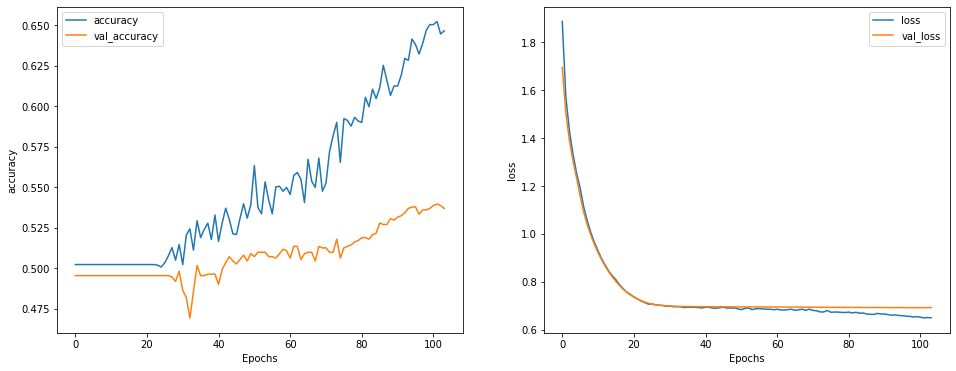

In [279]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [177]:
sample = format_text_to_one_hot(["What do you call a Frenchman wearing sandals? Philippe Philoppe.",
"Two whales walk into a bar. The first whale says to the other, 'WOOOOOO. WEEEEEEEEOOOOO. WEEEEEEEEEEEEOOOOOOOOO.' The second whale says, 'Shut up Steve, you're drunk.'",
"'Did you know it takes three sheep to make a sweater?' 'I didn't know sheep could knit.'", "This is not funny", "Hey", "example"])
sample_labels = [1, 1, 1, 0]

#result = model.predict(sample)


48


In [ ]:
print(result)